# Cat and Dog Dataset - GoogLeNet 으로 학습
- Cats and Dogs dataset to train DL model
- 캐글의 [Cat and Dog](https://www.kaggle.com/tongpython/cat-and-dog)

In [1]:
import tensorflow as tf
import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### 데이터 다운로드

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# permmision warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip -d catanddog/
data_dir = './catanddog/'

### 데이터 적재

In [9]:
train_cats =glob.glob(data_dir + '/training_set/training_set/cats/*.jpg')
train_dogs =glob.glob(data_dir + '/training_set/training_set/dogs/*.jpg')

test_cats =glob.glob(data_dir + '/test_set/test_set/cats/*.jpg')
test_dogs =glob.glob(data_dir + '/test_set/test_set/dogs/*.jpg')

In [10]:
print(len(train_cats), len(train_dogs))
print(len(test_cats), len(test_dogs))

4000 4005
1011 1012


### 데이터 시각화

In [ ]:
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)

dog_filepaths = train_dogs[:4]

for i in range(4):
    dog_image = cv2.cvtColor(cv2.imread(dog_filepaths[i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(dog_image)
    
figure, axes = plt.subplots(figsize=(22, 6), nrows=1, ncols=4)

cat_filepaths = train_cats[:4]

for i in range(4):
    cat_image = cv2.cvtColor(cv2.imread(cat_filepaths[i]), cv2.COLOR_BGR2RGB)
    axes[i].imshow(cat_image)
    

### 데이터 전처리 (using "from dataframe")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


# train_df
train_path = train_cats + train_dogs # 4000 4005 (Cat/Dog)
train_label = ["CAT" for _ in range(len(train_cats))] + ["DOG" for _ in range(len(train_dogs))]
train_df = pd.DataFrame({"path":train_path, "label":train_label})


# test_df
test_paths = test_cats + test_dogs # 1011 1012 (Cat/Dog)
test_label = ["CAT" for _ in range(len(test_cats))] + ["DOG" for _ in range(len(test_dogs))]
test_df = pd.DataFrame({"path":test_paths, "label":test_label})

# valid_df
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(train_df['label'].value_counts())
print(valid_df['label'].value_counts())

In [ ]:
pd.set_option("display.max_colwidth", 200)
train_df.head()

In [ ]:
BATCH_SIZE = 64
# train_generator
train_generator = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 20, 
                                    rescale = 1/255.0
                                    ) # 다양한 Augmentation 시도해보기!!!
train_generator_iterator = train_generator.flow_from_dataframe(dataframe=train_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=True)

# valid_generator
valid_generator = ImageDataGenerator(rescale = 1/255.0)

valid_generator_iterator = valid_generator.flow_from_dataframe(dataframe=valid_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)


# test_generator
test_generator = ImageDataGenerator(rescale = 1/255.0)

test_generator_iterator = test_generator.flow_from_dataframe(dataframe=test_df,
                                                               x_col = 'path',
                                                               y_col = 'label',
                                                               target_size = (224, 224), class_mode = "binary",
                                                               batch_size = BATCH_SIZE, shuffle=False)

In [ ]:
train_batch, label_batch = next(train_generator_iterator)
train_batch.shape, label_batch.shape

### 모델 생성 및 학습

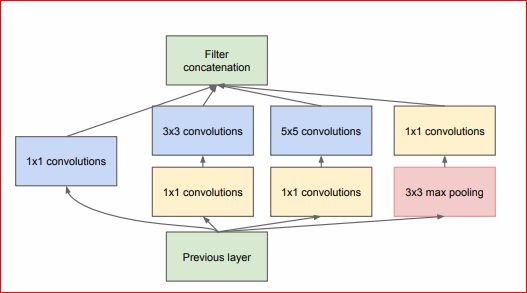

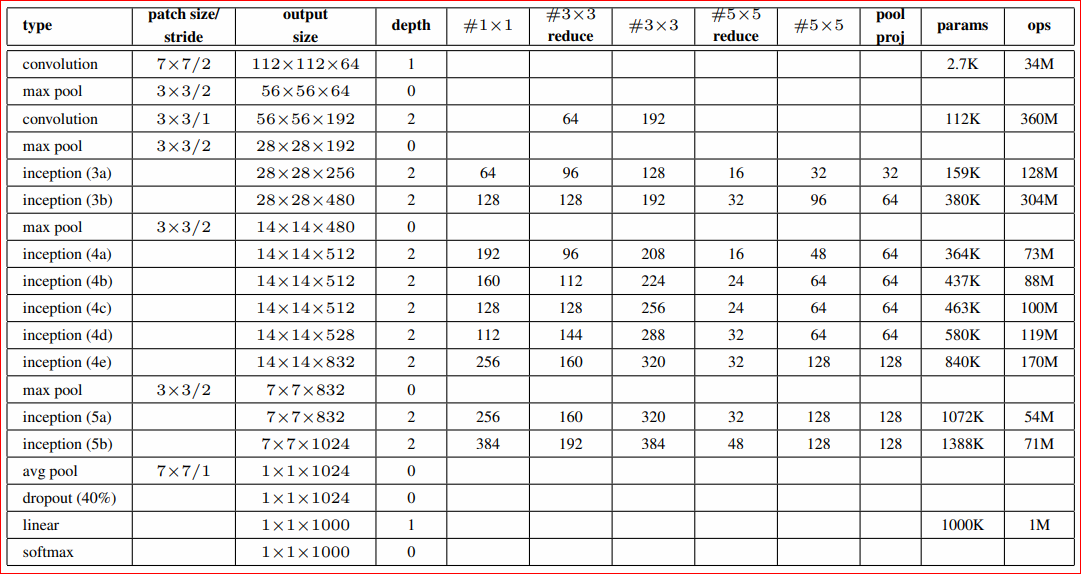

In [11]:
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool, name ):
    # 1X1 Conv
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding="same", activation="relu")(x)

    # 3X3 적용전 1X1 Conv
    reduce_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding="same", activation="relu")(x)
    # 3X3 Conv
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding="same", activation="relu")(reduce_3x3)

    # 5X5 적용전 1X1 Conv
    reduce_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding="same", activation="relu")(x)
    # 5X5 Conv
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding="same", activation="relu")(reduce_5x5)

    # Max Pooling Proj.
    pool = MaxPooling2D((3,3), strides=(1,1), padding="same")(x)
    pool_proj = Conv2D(filters_pool, (1, 1), padding="same", activation="relu")(pool)

    # Concatenate
    # (batch(axis=0), height(axis=1), width(axis=2), depth(axis=3))
    output = Concatenate(axis=-1, name=name)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    
    return output

In [ ]:
IMAGE_SIZE = 224

def build_GoogLeNet():
    tf.keras.backend.clear_session()
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = Conv2D(filters=64, kernel_size=(7, 7), padding="same", strides=(2, 2), activation="relu")(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = Conv2D(filters=64, kernel_size=(1, 1), padding="same", strides=(1, 1), activation="relu")(x)
    x = Conv2D(filters=192, kernel_size=(3, 3), padding="same", strides=(1, 1), activation="relu")(x)
    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)
    
    # 인셉션 모듈 3a
    x = inception_module(x, 64, 96, 128, 16, 32, 32, name="inception_3a")
    # 인셉션 모듈 3b
    x = inception_module(x, 128, 128, 192, 32, 96, 64, name="inception_3b")

    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)

    # 인셉션 모듈 4a
    x = inception_module(x, 192, 96, 208, 16, 48, 64, "inception_4a")
    # 인셉션 모듈 4b
    x = inception_module(x, 160, 112, 224, 24, 64, 64, name="inception_4b")
    # 인셉션 모듈 4c
    x = inception_module(x, 128, 128, 256, 24, 64, 64, name="inception_4c")
    # 인셉션 모듈 4d
    x = inception_module(x, 112, 144, 288, 32, 64, 64, name="inception_4d")
    # 인셉션 모듈 4e
    x = inception_module(x, 256, 160, 320, 32, 128, 128, name="inception_4e")

    x = MaxPooling2D(pool_size=(3, 3), padding="same", strides=(2, 2))(x)

    # 인셉션 모듈 5a
    x = inception_module(x, 256, 160, 320, 32, 128, 128, name="inception_5a")
    # 인셉션 모듈 5b
    x = inception_module(x, 384, 192, 384, 48, 128, 128, name="inception_5b")

    x = GlobalAveragePooling2D()(x) 
    x = Dropout(0.4)(x)    
    output = Dense(units=1, activation='sigmoid')(x)


    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'] )
    return model

model = build_GoogLeNet()
model.summary()

In [ ]:
import os
import time
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

In [ ]:
run_logdir = get_run_logdir()
checkpoint_cb = ModelCheckpoint("my_best_model.h5", monitor="val_loss", save_best_only = True, verbose=1)
early_stopping_cb = EarlyStopping( monitor="val_loss", patience=15, verbose=1, restore_best_weights=False)
reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1)
tensorboard_cb = TensorBoard(run_logdir)

In [ ]:
history = model.fit(train_generator_iterator, validation_data=valid_generator_iterator, epochs=40, 
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, tensorboard_cb])

### 모델 평가

In [ ]:
model.evaluate(test_generator_iterator)

In [ ]:
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

In [ ]:
plt.plot(history.history['accuracy'], label="train accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

In [ ]:
%load_ext tensorboard 
%tensorboard --logdir=./my_logs --port=6006